# KFold DRNN Scale Thickness Prediction

# Step - 0: Configurations

## Step - 0.1: Managing Dependencies

### Installing Libraries

!pip install tensorflow==2.1.0

!pip install matplotlib==3.1.0

### Importing Libraries

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
#import feather
import pickle

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from math import sqrt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedShuffleSplit

from tensorflow import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Libraries Versions

In [2]:
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.1.0


## Step - 0.2: Setting Random Seed

In [3]:
seed = 1632
np.random.seed(seed)
random.set_seed(seed)

## Step - 0.3: Mounting Cloud Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

## Step - 0.4: Managing Global Variables

### Setting Variables

In [4]:
#List with the Neural Networks Types Options
NN_MODEL_TYPE_LIST = ["FNN", "RNN", "CNN"]

#Neural Networks Type
NN_MODEL_TYPE = NN_MODEL_TYPE_LIST[0]

#List with the Neural Networks Architectures Options
NN_MODEL_ARCHITECTURE_LIST = ["DRNN", "LSTM", "FCN"]

#Neural Networks Architectures
NN_MODEL_ARCHITECTURE = NN_MODEL_ARCHITECTURE_LIST[0]

### Setting Paths

#### Root Path

In [5]:
#Path to The Project Directory
#ROOT_PATH = "/content/gdrive/My Drive/Projetos/9 - Deep Learning para Predicao de Espessura de Tubulacoes/excentrica"
ROOT_PATH = "F:/Kon/Documents/Google Drive LMP/Projetos/9 - Deep Learning para Predicao de Espessura de Tubulacoes/excentrica"
ROOT_DIR = Path(ROOT_PATH)
print("Root Path:", ROOT_DIR)

Root Path: F:\Kon\Documents\Google Drive LMP\Projetos\9 - Deep Learning para Predicao de Espessura de Tubulacoes\excentrica


#### Data Path

In [6]:
#Datasets Paths
DATASET_DIR = Path(ROOT_DIR/'data')

#Raw Datasets
DATASET_RAW_DIR = DATASET_DIR / 'raw'
DATASET_RAW_TRAIN_DIR = DATASET_RAW_DIR /'train'
DATASET_RAW_VALID_DIR = DATASET_RAW_DIR /'valid'
DATASET_RAW_TEST_DIR = DATASET_RAW_DIR /'test'
DATASET_RAW_HOLDOUT_DIR = DATASET_RAW_DIR /'holdout'

#Raw Datasets
DATASET_INTERIM_DIR = DATASET_DIR / 'interim'
DATASET_INTERIM_TRAIN_DIR = DATASET_INTERIM_DIR /'train'
DATASET_INTERIM_VALID_DIR = DATASET_INTERIM_DIR /'valid'
DATASET_INTERIM_TEST_DIR = DATASET_INTERIM_DIR /'test'
DATASET_INTERIM_HOLDOUT_DIR = DATASET_INTERIM_DIR /'holdout'

#### Report Path

In [7]:
#Path to Save Reports
REPORT_MODEL_DIR = Path(ROOT_DIR/'reports'/'regression_classification'/NN_MODEL_TYPE)

METRICS_DIR = Path(REPORT_MODEL_DIR/'metrics')
METRICS_VALUES_DIR = Path(METRICS_DIR/"values") 
METRICS_VALUES_RAW_DIR = Path(METRICS_VALUES_DIR/"raw") 
METRICS_VALUES_TRAIN_DIR = Path(METRICS_VALUES_DIR/"train") 
METRICS_VALUES_VALID_DIR = Path(METRICS_VALUES_DIR/"valid") 
METRICS_VALUES_TEST_DIR = Path(METRICS_VALUES_DIR/"test") 
METRICS_VALUES_HOLDOUT_DIR = Path(METRICS_VALUES_DIR/"holdout") 

METRICS_PLOTS_DIR = Path(METRICS_DIR/"plots") 
METRICS_PLOTS_ENTROPY_DIR = Path(METRICS_PLOTS_DIR/"entropy") 
METRICS_PLOTS_MAE_DIR = Path(METRICS_PLOTS_DIR/"mae") 
METRICS_PLOTS_MSE_DIR = Path(METRICS_PLOTS_DIR/"mse")
METRICS_PLOTS_RMSE_DIR = Path(METRICS_PLOTS_DIR/"rmse")

REGRESSION_CLASSIFICATION_REPORT_DIR = Path(REPORT_MODEL_DIR/"reports")
REGRESSION_CLASSIFICATION_REPORT_RAW_DIR = Path(REGRESSION_CLASSIFICATION_REPORT_DIR/"raw")
REGRESSION_CLASSIFICATION_REPORT_TEST_DIR = Path(REGRESSION_CLASSIFICATION_REPORT_DIR/"test")
REGRESSION_CLASSIFICATION_REPORT_HOLDOUT_DIR = Path(REGRESSION_CLASSIFICATION_REPORT_DIR/"holdout")

CONFUSION_MATRIX_DIR = Path(REPORT_MODEL_DIR/'confusion_matrix')
CONFUSION_MATRIX_RAW_DIR = Path(CONFUSION_MATRIX_DIR/'raw')
CONFUSION_MATRIX_TEST_DIR = Path(CONFUSION_MATRIX_DIR/'test')
CONFUSION_MATRIX_HOLDOUT_DIR = Path(CONFUSION_MATRIX_DIR/'holdout')

CONFUSION_MATRIX_RAW_NO_NORM_DIR = Path(CONFUSION_MATRIX_RAW_DIR/'no_norm')
CONFUSION_MATRIX_RAW_NORM_DIR = Path(CONFUSION_MATRIX_RAW_DIR/'norm')

CONFUSION_MATRIX_TEST_NO_NORM_DIR = Path(CONFUSION_MATRIX_TEST_DIR/'no_norm')
CONFUSION_MATRIX_TEST_NORM_DIR = Path(CONFUSION_MATRIX_TEST_DIR/'norm')

CONFUSION_MATRIX_HOLDOUT_NO_NORM_DIR = Path(CONFUSION_MATRIX_HOLDOUT_DIR/'no_norm')
CONFUSION_MATRIX_HOLDOUT_NORM_DIR = Path(CONFUSION_MATRIX_HOLDOUT_DIR/'norm')

# Step - 1: Data Ingestion

In [8]:
def display_all(df, m=100):
  with pd.option_context("display.max_rows", m, "display.max_columns", m): 
    display(df.head(m))

## Step - 1.1: Data Loading

### Data Loading Function Definition

In [9]:
def data_loading(file_dir,
                 file_name):
    new_df = pd.DataFrame()
    for idx in [0, 30, 60, 90]:
        #file_new_name = file_name+str(idx)+".xlsx"
        file_new_name = file_name+str(idx)+"_0_01.xlsx"
        df = pd.read_excel(file_dir/str(idx)/file_new_name)
        new_df = new_df.append(df)
    return new_df

### Loading Raw Data

In [10]:
data_raw = data_loading(DATASET_RAW_TRAIN_DIR, "raw_")

### Loading Train Data

In [11]:
data_train = data_raw

# Step - 3: Data Preprocessing

## Step - 3.0: Data Spliting

## Step - 3.1: Feature Engineering

### Normalizing, Encoding, Reshaping Features and Target

#### Defining Features Normalizing Function

In [12]:
def feature_normalization(X, normalizer=None):
    if(normalizer==None):
        normalizer = MinMaxScaler(feature_range = (0, 1))
        #normalizer = StandardScaler()
        X = normalizer.fit_transform(X)
        return X, normalizer
    else:
        X = normalizer.transform(X)
        return X

In [13]:
def encoding(y, encoder=None):
    if(encoder==None):
        encoder = LabelEncoder()
        y = encoder.fit_transform(y)
        #y = to_categorical(y)
        return y, encoder
    else:
        y = encoder.transform(y)
        #y = to_categorical(y)
        return y

In [14]:
def decoder(y, encoder):
  from tensorflow import  argmax
  #y = argmax(y, axis=1)
  y = encoder.inverse_transform(y)
  return y

### Defining Data Preprocessing Function

In [15]:
def preprocessing(data, normalizer = None, encoder=None):
    df = data.copy()
    if(encoder==None) or (normalizer==None):
        X,normalizer = feature_normalization(df.iloc[:, :-2].values)
        X = X.astype("float32")
        y = df.iloc[:, -2:].values
        #y,encoder = encoding(df.iloc[:, -2:].values)
        return X, y, normalizer
    else:
        X = feature_normalization(df.iloc[:, :-2].values, normalizer)
        X = X.astype("float32")
        y = df.iloc[:, -2:].values
        #y = encoding(df.iloc[:, -2:].values, encoder)
        return X, y

### Executing Data Preprocessing Function

In [16]:
data_train["Posicao"] = data_train["Posicao"].astype('category').cat.codes

#### Raw Data

In [17]:
X, y, normalizer = preprocessing(data_train.iloc[:,:], normalizer=None)

In [18]:
print("Formato Dados X:,", X.shape)
print("Formato Dados y:", y.shape)

Formato Dados X:, (5204, 133)
Formato Dados y: (5204, 2)


## Step - 4.1: Model Training 

### Defining Function to Create the Neural Network Model

In [19]:
def create_model():

    inputs = layers.Input(name="input", shape=(133,))
    layer1 = layers.Dense(700, activation='relu', name="layer1")(inputs)
    layer2 = layers.Dense(800, activation='relu',  name="layer2")(layer1)
    layer3 = layers.Dense(300, activation='relu',  name="layer3")(layer2)
    layer4 = layers.Dense(600, activation='relu',  name="layer4")(layer3)
    layer5 = layers.Dense(800, activation='relu',  name="layer5")(layer4)
    classifier = layers.Dense(4, activation='softmax', name="classifier")(layer5)
    mdl = models.Model(inputs=inputs, outputs=classifier)

    regressor = layers.Dense(1, activation='linear',name="regressor")(layer5)
    mdl = models.Model(inputs=inputs, outputs=[classifier, regressor])    
    
    #Resumo do Modelo
    mdl.summary()
    
    return mdl

### Defining Function to Train the Neural Network Model

In [20]:
def train_model(model, 
                X_train, y_train,
                X_val, y_val, 
                epochs=100, 
                es_patience=25,
                filepath_model="", 
                filepath_model_history=""):
    
    es = EarlyStopping(monitor='val_regressor_loss', mode='min', verbose=1, patience=es_patience)
    
    callback_checkpoint = ModelCheckpoint(filepath=filepath_model,
                                          monitor='val_regressor_mae', 
                                          mode='min',
                                          save_weights_only=False,
                                          save_best_only=True,
                                          verbose=1)
    callbacks = [callback_checkpoint, es]
    
    model.compile(loss=["sparse_categorical_crossentropy", "mse",],
                  loss_weights=[0.25, 10],
                  optimizer="adam", 
                  metrics=['mae', "accuracy"])
    # fit network

    history = model.fit(X_train, y_train, 
                      epochs=epochs, 
                      validation_data=(X_val, y_val),
                      callbacks=callbacks,
                      shuffle=True,
                      verbose=2)

    with open(filepath_model_history, 'wb') as output_file:
        pickle.dump(history.history, output_file)

### Setting Hyperparamenters

#### Train Parameters

In [21]:
#Quantidade de Épocas de Treinamento
epochs = 10000

#Quantidade de Épocas que devem ser Aguardadas para Terminar o Treinamento
#Caso não Haja uma Melhora no Treinamento
es_patience = 1000

### Executing Function to Create Neural Network Model

model = create_model()

### Cross Validation

In [22]:
kfold_num = 10
#kf = KFold(kfold_num, shuffle=True) # Use for KFold classification
kf = StratifiedShuffleSplit(kfold_num, test_size=0.2, random_state=seed)
list_X_train = []
list_y_train = []
list_X_test = []
list_y_test = []
list_model = []
fold = 0

In [23]:
for train, test in kf.split(X, y[:,1]):
    fold+=1
    kfold_name = 'kfold_'+str(fold)
    print(f"Fold #{fold}")
    
    #Neural Network Model Name
    TRAINED_NN_MODEL_NAME = "hyperas_model"+NN_MODEL_TYPE+"_"+NN_MODEL_ARCHITECTURE+"_"+kfold_name
    #Path to Save Trained Models
    TRAINED_MODEL_PATH = ROOT_PATH+'/models/'+'/regression_classification/'+NN_MODEL_TYPE+'/'+kfold_name
    TRAINED_MODEL_DIR = Path(ROOT_DIR/'models'/'regression_classification'/NN_MODEL_TYPE/kfold_name)
    TRAINED_MODEL_FILE = (TRAINED_MODEL_PATH+"/"+(TRAINED_NN_MODEL_NAME+".hdf5"))
    TRAINED_MODEL_HISTORY_FILE = Path(TRAINED_MODEL_DIR/(TRAINED_NN_MODEL_NAME+".pickle"))
    
    X_train = X[train]
    X_test = X[test]

    y_train = y[train]
    y_test = y[test]
    
    print("Formato Dados X_train:,", X_train.shape)
    print("Formato Dados y_train:", y_train.shape)

    print("Formato Dados X_test:", X_test.shape)
    print("Formato Dados y_test:", y_test.shape) 
    
    #train_model(model, 
    #            X_train, [y_train[:,1],y_train[:,0]],
    #            X_test, [y_test[:,1],y_test[:,0]], 
    #            epochs, 
    #            es_patience,
    #            filepath_model=TRAINED_MODEL_FILE,
    #           filepath_model_history=TRAINED_MODEL_HISTORY_FILE) 
    
    list_X_train.append(X_train)
    list_X_test.append(X_test)
    list_y_train.append(y_train)
    list_y_test.append(y_test)
    #list_model.append(model)

Fold #1
Formato Dados X_train:, (4163, 133)
Formato Dados y_train: (4163, 2)
Formato Dados X_test: (1041, 133)
Formato Dados y_test: (1041, 2)
Fold #2
Formato Dados X_train:, (4163, 133)
Formato Dados y_train: (4163, 2)
Formato Dados X_test: (1041, 133)
Formato Dados y_test: (1041, 2)
Fold #3
Formato Dados X_train:, (4163, 133)
Formato Dados y_train: (4163, 2)
Formato Dados X_test: (1041, 133)
Formato Dados y_test: (1041, 2)
Fold #4
Formato Dados X_train:, (4163, 133)
Formato Dados y_train: (4163, 2)
Formato Dados X_test: (1041, 133)
Formato Dados y_test: (1041, 2)
Fold #5
Formato Dados X_train:, (4163, 133)
Formato Dados y_train: (4163, 2)
Formato Dados X_test: (1041, 133)
Formato Dados y_test: (1041, 2)
Fold #6
Formato Dados X_train:, (4163, 133)
Formato Dados y_train: (4163, 2)
Formato Dados X_test: (1041, 133)
Formato Dados y_test: (1041, 2)
Fold #7
Formato Dados X_train:, (4163, 133)
Formato Dados y_train: (4163, 2)
Formato Dados X_test: (1041, 133)
Formato Dados y_test: (1041, 2)

## Step - 4.2: Model Evaluation

### Load Models

In [24]:
def loading_models(folds):
    list_model = []
    for fold in range(1, folds+1):
        kfold_name = 'kfold_'+str(fold)
        TRAINED_NN_MODEL_NAME = "hyperas_model"+NN_MODEL_TYPE+"_"+NN_MODEL_ARCHITECTURE+"_"+kfold_name
        #Path to Save Trained Models
        TRAINED_MODEL_PATH = ROOT_PATH+'/models/'+'/regression_classification/'+NN_MODEL_TYPE+'/'+kfold_name
        TRAINED_MODEL_DIR = Path(ROOT_DIR/'models'/'regression_classification'/NN_MODEL_TYPE/kfold_name)
        TRAINED_MODEL_FILE = (TRAINED_MODEL_PATH+"/"+(TRAINED_NN_MODEL_NAME+".hdf5"))
  
        try:
            model = load_model(TRAINED_MODEL_FILE)
        except Exception as error:
            print("Erro ao Carregar o Modelo:",TRAINED_MODEL_FILE)
            print(error)
        list_model.append(model)
    return list_model

In [25]:
list_model = loading_models(kfold_num)

### KFold Metrics

#### Defining Function to Generate KFold Metrics Values

In [26]:
def metrics_kfold_eval(list_model, list_X, list_y, file_title, file_path):
    df = pd.DataFrame(columns=["Dataset", 
                               "Mean Absolute Error",
                               "Mean Squared Error",
                               "Root Mean Squared Error",
                               "Mean Relative Error",
                               "R2 Score",
                               "Max Absolute Error",
                               "Max Relative Error"])
    from math import sqrt

    for kfold in range(0, len(list_model)):
        print(kfold)
        X = list_X[kfold]
        y = list_y[kfold]
        model = list_model[kfold]
        #model = list_model[9]
        y_pred = model.predict(X)
        y = y[:,0]
        y_pred = y_pred[1]
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = sqrt(mse)
        r2 = r2_score(y, y_pred)
        me = max_error(y, y_pred)
        
        absolute_deviation_vec = np.zeros(y.shape[0])
        absolute_percent_deviation_vec = np.zeros(y.shape[0])
    
        for i in range(0, y_pred.shape[0]):
            absolute_deviation_vec[i] = abs(y[i] - y_pred[i])
            absolute_percent_deviation_vec[i] = (absolute_deviation_vec[i]/y[i])*100 
        mrl= np.amax(absolute_percent_deviation_vec)
        rpe = np.mean(absolute_percent_deviation_vec)
        
        file = Path(file_path/file_title)
        print("KFold #"+str(kfold+1))
        print("Mean Absolute Error:", mae)
        print("Mean Squared Error:", mse)
        print("Root Mean Squared Error:", rmse)
        print("Mean Relative Error:", rpe)
        print("R2 Score:", r2)
        print("Max Absolue Error:", me)
        print("Max Relative Error:", mrl)
        print('')
        
        df.loc[kfold] = ["KFold #"+str(kfold+1), 
                         mae, 
                         mse, 
                         rmse,
                         rpe,
                         r2, 
                         me,
                         mrl]
    df.to_excel(file)

## Regression Metrics

#### Training Metrics Values

##### Running Function to Generate the Metrics Values for the Training Set

In [27]:
metrics_kfold_eval(list_model, list_X_train, list_y_train, "_train_metrics_"+TRAINED_NN_MODEL_NAME+".xlsx", METRICS_VALUES_TRAIN_DIR)

0
KFold #1
Mean Absolute Error: 0.018155996551486697
Mean Squared Error: 0.0016202178804033004
Root Mean Squared Error: 0.04025193014506634
Mean Relative Error: 0.3051665637148221
R2 Score: 0.9998843207487624
Max Absolue Error: 0.44109092712402287
Max Relative Error: 23.740623511520088

1
KFold #2
Mean Absolute Error: 0.01912325891141629
Mean Squared Error: 0.0017025916746793116
Root Mean Squared Error: 0.04126247295884375
Mean Relative Error: 0.31608164490385104
R2 Score: 0.9998793486859126
Max Absolue Error: 0.43261146545410156
Max Relative Error: 5.08663007768534

2
KFold #3
Mean Absolute Error: 0.017528739961155736
Mean Squared Error: 0.0016089032575577911
Root Mean Squared Error: 0.04011113632842868
Mean Relative Error: 0.3064126255270762
R2 Score: 0.9998846130525646
Max Absolue Error: 0.4472646713256836
Max Relative Error: 6.257867813110352

3
KFold #4
Mean Absolute Error: 0.01697486416296383
Mean Squared Error: 0.0016093309125656873
Root Mean Squared Error: 0.04011646685048033
M

#### Test Metrics Values

##### Running Function to Generate the Metrics Values for the Testing Set

In [28]:
metrics_kfold_eval(list_model, list_X_test, list_y_test, "_test_metrics_"+TRAINED_NN_MODEL_NAME+".xlsx", METRICS_VALUES_TEST_DIR)

0
KFold #1
Mean Absolute Error: 0.020438234961800375
Mean Squared Error: 0.0024847782468477215
Root Mean Squared Error: 0.04984755005863098
Mean Relative Error: 0.30818616282930617
R2 Score: 0.9998286005479782
Max Absolue Error: 0.4089090728759768
Max Relative Error: 3.1631752519577465

1
KFold #2
Mean Absolute Error: 0.020038630669216767
Mean Squared Error: 0.002118505094543365
Root Mean Squared Error: 0.046027221234214925
Mean Relative Error: 0.32418669931128324
R2 Score: 0.9998495177077609
Max Absolue Error: 0.42738853454589787
Max Relative Error: 6.1836134303699835

2
KFold #3
Mean Absolute Error: 0.018817101402080694
Mean Squared Error: 0.002044191447333816
Root Mean Squared Error: 0.04521273545511061
Mean Relative Error: 0.31857312540857297
R2 Score: 0.9998613681748556
Max Absolue Error: 0.4372646713256838
Max Relative Error: 4.037642011455461

3
KFold #4
Mean Absolute Error: 0.017521743877475814
Mean Squared Error: 0.0019964378848035575
Root Mean Squared Error: 0.044681516142623

### Regression Report

In [29]:
def save_objects(obj_name, some_obj):
    with open(obj_name, 'wb') as f:
        pickle.dump(some_obj, f)

save_objects("list_X_train.pickle", list_X_train)
save_objects("list_y_train.pickle", list_y_train)
save_objects("list_X_test.pickle", list_X_test)
save_objects("list_y_test.pickle", list_y_test)

save_objects("list_model.pickle", list_model)

In [57]:
best_fold = 3
best_model = list_model[best_fold]
best_X_train = list_X_train[best_fold] 
best_y_train = list_y_train[best_fold]
best_X_test = list_X_test[best_fold] 
best_y_test = list_y_test[best_fold]

In [58]:
def inverse_categorical(arr):
    arr = np.where(arr==0, 0, arr)
    arr = np.where(arr==1, 30, arr)
    arr = np.where(arr==2, 60, arr)
    arr = np.where(arr==3, 90, arr)
    return arr

In [59]:
def prediction_output(y_true, y_pred):
    y_true_regression = y_true[:,0] 
    y_true_classification = y_true[:,1] 

    y_pred_regression = y_pred[1] 
    y_pred_classification = np.argmax(y_pred[0], axis=1)
    
    absolute_deviation_vec = np.zeros(y_true_regression.shape[0])
    absolute_percent_deviation_vec = np.zeros(y_true_regression.shape[0])
    
    for i in range(0, y_pred_regression.shape[0]):
        absolute_deviation_vec[i] = abs(y_true_regression[i] - y_pred_regression[i])
        absolute_percent_deviation_vec[i] = (absolute_deviation_vec[i]/y_true_regression[i])*100    
    
    s1 = pd.DataFrame(inverse_categorical(y_true_classification), columns = ["Real Scale Position"])
    s2 = pd.DataFrame(inverse_categorical(y_pred_classification), columns = ["DRNN Scale Position"])
    s3 = pd.DataFrame(y_true_regression, columns = ["Real Scale Thickness"])
    s4 = pd.DataFrame(y_pred_regression, columns = ["DRNN Scale Thickness"])
    s5 = pd.DataFrame(absolute_deviation_vec, columns = ["Scale Thickness Absolute Error"])
    s6 = pd.DataFrame(absolute_percent_deviation_vec, columns = ["Scale Thickness Relative Error"])
    df = pd.concat([s1, s2, s3, s4, s5, s6], axis=1)
    df.index += 1
    return df

In [68]:
y_pred = best_model.predict(best_X_train)

In [69]:
df_pred = prediction_output(best_y_train, y_pred)

In [70]:
file_name = str(best_fold+1)+"train_fold_report_"+TRAINED_NN_MODEL_NAME+".xlsx"
df_pred = df_pred.sort_values(by=['Real Scale Position', 
                                  'Real Scale Thickness',
                                  'Scale Thickness Relative Error'], 
                                  ascending=True)
df_pred.to_excel(REGRESSION_CLASSIFICATION_REPORT_TEST_DIR/file_name)

In [71]:
display_all(df_pred, 1200)

,Real Scale Position,DRNN Scale Position,Real Scale Thickness,DRNN Scale Thickness,Scale Thickness Absolute Error,Scale Thickness Relative Error
2894,0.0,0,0.50,0.490858,0.009142,1.828432
786,0.0,0,0.51,0.512497,0.002497,0.489670
328,0.0,0,0.52,0.523889,0.003889,0.747878
1853,0.0,0,0.53,0.536102,0.006102,1.151359
3229,0.0,0,0.54,0.548500,0.008500,1.574103
1185,0.0,0,0.56,0.563021,0.003021,0.539518
2239,0.0,0,0.57,0.574796,0.004796,0.841377
1963,0.0,0,0.58,0.575651,0.004349,0.749816
1945,0.0,0,0.60,0.599546,0.000454,0.075738
2176,0.0,0,0.61,0.615497,0.005497,0.901183


In [64]:
df_pred.groupby(pd.cut(df_pred['Scale Thickness Relative Error'], np.arange(0,100,1))).count()

,Real Scale Position,DRNN Scale Position,Real Scale Thickness,DRNN Scale Thickness,Scale Thickness Absolute Error,Scale Thickness Relative Error
Scale Thickness Relative Error,,,,,,
"(0, 1]",966,966,966,966,966,966
"(1, 2]",50,50,50,50,50,50
"(2, 3]",19,19,19,19,19,19
"(3, 4]",4,4,4,4,4,4
"(4, 5]",1,1,1,1,1,1
...,...,...,...,...,...,...
"(94, 95]",0,0,0,0,0,0
"(95, 96]",0,0,0,0,0,0
"(96, 97]",0,0,0,0,0,0


### Classification with the Model

In [56]:
y_pred = best_model.predict(best_X_test)
y_pred = np.argmax(y_pred[0], axis=1)

In [57]:
def saving_classification_report(y, y_pred, file_title, file_path):
    file_title = file_title+".txt"
    file = Path(file_path/file_title)
    print(classification_report(y, y_pred))
    with open(file, 'w') as f:
        print(classification_report(y, y_pred), file=f)

In [58]:
saving_classification_report(inverse_categorical(best_y_test[:,1]), inverse_categorical(y_pred), str(best_fold+1)+"_fold_classification_report_"+TRAINED_NN_MODEL_NAME, METRICS_VALUES_TEST_DIR)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       260
        30.0       1.00      1.00      1.00       260
        60.0       1.00      1.00      1.00       261
        90.0       1.00      1.00      1.00       260

    accuracy                           1.00      1041
   macro avg       1.00      1.00      1.00      1041
weighted avg       1.00      1.00      1.00      1041



In [40]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize = (12,8),
                          cm_path="",
                          want_save=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.rcParams.update({'font.size': 12})
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    if(want_save == True and normalize == True):
        title_cm = ("Normalized_Confusion_Matrix - "+str(title))
        plt.savefig(cm_path/title_cm, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
    if(want_save == True and normalize == False):
        title_cm = ("Confusion_Matrix - "+str(title))
        plt.savefig(cm_path/title_cm, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

In [41]:
cm = confusion_matrix(inverse_categorical(best_y_test[:,1]), inverse_categorical(y_pred))

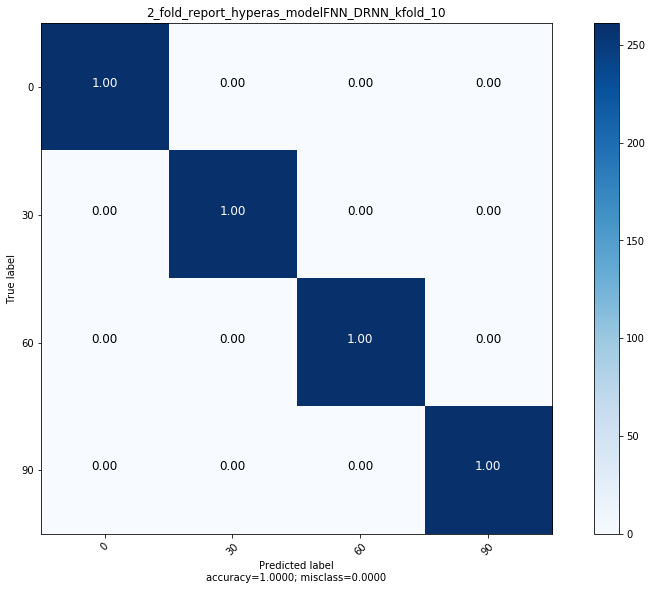

In [42]:
plot_confusion_matrix(cm, 
                      target_names = ['0','30','60','90'], 
                      normalize = True, 
                      title = str(best_fold+1)+"_fold_report_"+TRAINED_NN_MODEL_NAME,
                      cm_path = CONFUSION_MATRIX_TEST_NORM_DIR,
                      want_save = True)

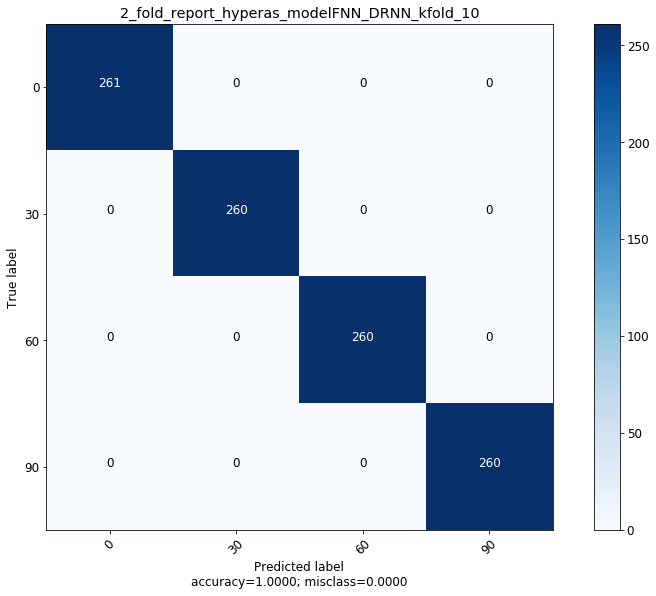

In [43]:
plot_confusion_matrix(cm, 
                      target_names = ['0','30','60','90'], 
                      normalize = False, 
                      title = str(best_fold+1)+"_fold_report_"+TRAINED_NN_MODEL_NAME,
                      cm_path = CONFUSION_MATRIX_TEST_NO_NORM_DIR,
                      want_save = True)

### Test

In [44]:
def metrics_regression_eval(model, X, y, file_title, file_path):
        df = pd.DataFrame(columns=["Mean Absolute Error",
                               "Mean Squared Error",
                               "Root Mean Squared Error",
                               "Mean Relative Error",
                               "R2 Score",
                               "Max Absolute Error",
                               "Max Relative Error"])

        from math import sqrt
        y_pred = model.predict(X)
        y = y[:,idx]
        y_pred = y_pred[1]
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = sqrt(mse)
        r2 = r2_score(y, y_pred)
        me = max_error(y, y_pred)

        absolute_deviation_vec = np.zeros(y.shape[0])
        absolute_percent_deviation_vec = np.zeros(y.shape[0])
    
        for i in range(0, y_pred.shape[0]):
            absolute_deviation_vec[i] = abs(y[i] - y_pred[i])
            absolute_percent_deviation_vec[i] = (absolute_deviation_vec[i]/y[i])*100 
        mrl= np.amax(absolute_percent_deviation_vec)
        rpe = np.mean(absolute_percent_deviation_vec)
        
        file = Path(file_path/file_title)
        print("Mean Absolute Error:", mae)
        print("Mean Squared Error:", mse)
        print("Root Mean Squared Error:", rmse)
        print("Mean Relative Error:", rpe)
        print("R2 Score:", r2)
        print("Max Absolue Error:", me)
        print("Max Relative Error:", mrl)
        print('')
        
        
        df.loc[0] = [mae, 
                     mse, 
                     rmse,
                     rpe,
                     r2, 
                     me,
                     mrl]
        
        df.to_excel(file)

In [45]:
X, y, normalizer = preprocessing(data_train.iloc[:,:], normalizer=None)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y[:,1], random_state=4230)

In [46]:
metrics_regression_eval(best_model, X_train, y_train, str(best_fold+1)+"_train_metrics_"+TRAINED_NN_MODEL_NAME+".xlsx", METRICS_VALUES_TRAIN_DIR)

Mean Absolute Error: 0.019081075590676944
Mean Squared Error: 0.0016841677785638166
Root Mean Squared Error: 0.041038613263167364
Mean Relative Error: 0.31761125780279503
R2 Score: 0.9998798201465035
Max Absolue Error: 0.43261146545410156
Max Relative Error: 6.1836134303699835



In [47]:
metrics_regression_eval(best_model, X_test, y_test, str(best_fold+1)+"_test_metrics_"+TRAINED_NN_MODEL_NAME+".xlsx", METRICS_VALUES_TEST_DIR)

Mean Absolute Error: 0.020207321941567522
Mean Squared Error: 0.002192182915377353
Root Mean Squared Error: 0.04682075304154508
Mean Relative Error: 0.3180696852002745
R2 Score: 0.9998484328734643
Max Absolue Error: 0.42738853454589787
Max Relative Error: 3.817326256207057



In [48]:
y_pred = best_model.predict(X_test)
df_pred = prediction_output(y_test, y_pred)
file_name = str(best_fold+1)+"_multi_out_regression_report_"+TRAINED_NN_MODEL_NAME+".xlsx"
df_pred = df_pred.sort_values(by=['Real Scale Position', 
                                  'Real Scale Thickness',
                                  'Scale Thickness Relative Error'], 
                                  ascending=True)
df_pred.to_excel(REGRESSION_CLASSIFICATION_REPORT_TEST_DIR/file_name)